In [1]:
import warnings
warnings.filterwarnings('ignore')

from TGA.utils import Dataset, Tokenizer

from tqdm.notebook import tqdm
import copy

from time import time
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [2]:
import matplotlib.pyplot as plt

In [3]:
from torch.nn.utils.rnn import pack_padded_sequence, pad_sequence

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

In [5]:
dataset = Dataset('/home/datasets/20ng/')
fold = next(dataset.get_fold_instances(10, with_val=True))
fold._fields, len(fold.X_train)

(('X_train', 'y_train', 'X_test', 'y_test', 'X_val', 'y_val'), 15062)

In [6]:
tokenizer = Tokenizer(mindf=1, stopwords='keep', model='sample', k=128, verbose=True)
tokenizer.fit(fold.X_train, fold.y_train)
tokenizer.vocab_size, tokenizer.N

100%|██████████| 15062/15062 [00:09<00:00, 1547.74it/s]


(99011, 15062)

In [7]:
from multiprocessing import Pool

In [8]:
y_train = tokenizer.le.transform( fold.y_train )
y_val   = tokenizer.le.transform( fold.y_val )
y_test  = tokenizer.le.transform( fold.y_test )

In [9]:
def collate_train(param):
    X, y = zip(*param)
    terms_ids, docs_offsets = tokenizer.transform(X, verbose=False)
    return torch.LongTensor(terms_ids), torch.LongTensor(docs_offsets), torch.LongTensor(y)

In [10]:
class Mask(nn.Module):
    def __init__(self, negative_slope=1000, kappa=2.):
        super(Mask, self).__init__()
        self.negative_slope = negative_slope
        self.kappa = kappa
        self.sig = nn.Sigmoid()
    def forward(self, h):
        w = F.leaky_relu( h, negative_slope=self.negative_slope)
        w = self.sig(w-self.kappa)
        return w

In [11]:
class SimpleAttentionBag(nn.Module):
    def __init__(self, vocab_size, hiddens, nclass, drop=.5, initrange=.5, negative_slope=99.):
        super(SimpleAttentionBag, self).__init__()
        self.hiddens        = hiddens
        self.dt_emb         = nn.Embedding(vocab_size, hiddens)
        self.tt_s_emb       = nn.Embedding(vocab_size, hiddens)
        self.tt_t_emb       = nn.Embedding(vocab_size, hiddens)
        self.fc             = nn.Linear(hiddens, nclass)
        #self.fc             = nn.Sequential(
        #    nn.Linear(hiddens, hiddens),
        #    nn.Sigmoid(),
        #    nn.Linear(hiddens, nclass)
        #)
        self.initrange      = initrange 
        self.negative_slope = negative_slope
        self.drop           = nn.Dropout(drop)
        self.norm           = nn.BatchNorm1d(hiddens)
        self.drop_          = drop
        self.sig            = nn.Sigmoid()
        self.init_weights()
    def forward(self, terms_idx, docs_offsets, return_mask=False):
        n = terms_idx.shape[0]
        batch_size = docs_offsets.shape[0]
        
        k         = [ terms_idx[ docs_offsets[i-1]:docs_offsets[i] ] for i in range(1, batch_size) ]
        k.append( terms_idx[ docs_offsets[-1]: ] )
        x_packed  = pad_sequence(k, batch_first=True, padding_value=0)

        bx_packed = x_packed == 0
        doc_sizes = bx_packed.logical_not().sum(dim=1).view(batch_size, 1)
        pad_mask  = bx_packed.logical_not()
        pad_mask  = pad_mask.view(*bx_packed.shape, 1)
        pad_mask  = pad_mask.logical_and(pad_mask.transpose(1, 2))
        
        dt_h     = self.dt_emb( x_packed )
        dt_h     = (bx_packed.logical_not().view(*bx_packed.shape, 1) * dt_h)
        dt_h     = F.dropout( dt_h, p=self.drop_, training=self.training )
        
        tt_h     = self.tt_s_emb( x_packed )
        #tt_dir_h = tt_h
        tt_dir_h = self.tt_t_emb( x_packed )
        
        tt_h = F.tanh(tt_h)
        tt_h = F.dropout( tt_h, p=self.drop_, training=self.training )
        
        tt_dir_h = self.norm(tt_dir_h.transpose( 1, 2 )).transpose( 1, 2 )
        tt_dir_h = F.tanh(tt_dir_h)
        tt_dir_h = F.dropout( tt_dir_h, p=self.drop_, training=self.training )
        
        co_weights = torch.bmm( tt_h, tt_dir_h.transpose( 1, 2 ) )
        co_weights = F.leaky_relu( co_weights, negative_slope=self.negative_slope)
        
        co_weights[pad_mask.logical_not()] = float('-inf') # Set the 3D-pad mask values to -inf (=0 in sigmoid)
        co_weights = F.sigmoid(co_weights)
        
        weights = co_weights.sum(axis=2) / doc_sizes
        weights[bx_packed] = float('-inf') # Set the 2D-pad mask values to -inf  (=0 in softmax)
        #weights[weights<.5] = float('-inf') # Set the 2D-pad mask values to -inf  (=0 in softmax)
        weights = F.softmax(weights, dim=1)
        weights = torch.where(torch.isnan(weights), torch.zeros_like(weights), weights)
        weights = weights.view( *weights.shape, 1 )
        
        docs_h = dt_h * weights
        docs_h = docs_h.sum(axis=1)
        docs_h = F.dropout( docs_h, p=self.drop_, training=self.training )
        docs_h = self.fc(docs_h)
        return docs_h, weights, co_weights
    
    """
    target_h = target_h.sum(axis=1) / doc_sizes
    target_h = target_h.view(*target_h.shape, 1).transpose(1,2)
    target_h = self.tt_target_map( target_h )
    target_h = (target_h - (dt_h/doc_sizes.view(*doc_sizes.shape, 1)))
    target_h = target_h * F.tanh(self.norm(target_h.transpose( 1, 2 )).transpose( 1, 2 ))
    target_h = F.dropout( target_h, p=self.drop_, training=self.training )
        """
    
    def init_weights(self):
        self.dt_emb.weight.data.uniform_(-self.initrange, self.initrange)
        self.tt_s_emb.weight.data.uniform_(-self.initrange, self.initrange)
        self.tt_t_emb.weight.data.uniform_(-self.initrange, self.initrange)
        #self.fc.weight.data.uniform_(-self.initrange, self.initrange)

In [36]:
nepochs = 1000
max_epochs = 20
drop=0.75
max_drop=0.75
device = torch.device('cuda:0')
batch_size = 64
k = 500

In [37]:
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)
torch.manual_seed(42)

In [38]:
#sc = SimpleClassifier(tokenizer.vocab_size, 300, tokenizer.n_class, dropout=drop).to( device )
ab = SimpleAttentionBag(tokenizer.vocab_size, 300, tokenizer.n_class, drop=drop).to( device )
#ab = AttentionBag(tokenizer.vocab_size, 300, tokenizer.n_class, drop=drop).to( device )
#ab = NotTooSimpleClassifier(tokenizer.vocab_size, 300, tokenizer.n_class, dropout1=drop, dropout2=drop).to( device )
tokenizer.k = k
optimizer = optim.AdamW( ab.parameters(), lr=5e-3, weight_decay=5e-3)
loss_func_cel = nn.CrossEntropyLoss().to( device )
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=.95,
                                                       patience=5, verbose=True)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=.98, verbose=True)

In [39]:
num_workers=16

In [40]:
best = 99999.
counter = 1
loss_val = 1.
eps = .9
dl_val = DataLoader(list(zip(fold.X_val, y_val)), batch_size=batch_size,
                         shuffle=False, collate_fn=collate_train, num_workers=num_workers)
for e in tqdm(range(nepochs), total=nepochs):
    dl_train = DataLoader(list(zip(fold.X_train, y_train)), batch_size=batch_size,
                             shuffle=True, collate_fn=collate_train, num_workers=num_workers)
    loss_train  = 0.
    with tqdm(total=len(y_train)+len(y_val), smoothing=0., desc=f"Epoch {e+1}") as pbar:
        total = 0
        correct  = 0
        ab.train()
        tokenizer.model = 'sample'
        #tokenizer.model = 'sample'
        for i, (terms_idx, docs_offsets, y) in enumerate(dl_train):
            terms_idx    = terms_idx.to( device )
            docs_offsets = docs_offsets.to( device )
            y            = y.to( device )
            
            pred_docs,_,_ = ab( terms_idx, docs_offsets)
            pred_docs     = F.softmax(pred_docs)
            loss          = loss_func_cel(pred_docs, y)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            loss_train += loss.item()
            total      += len(y)
            y_pred      = pred_docs.argmax(axis=1)
            correct    += (y_pred == y).sum().item()
            #ab.drop_ =  np.power((correct/total),loss_val)
            #ab.drop_ =  np.power((correct/total),4)
            ab.drop_ =  (correct/total)*max_drop
            
            toprint  = f"Train loss: {loss_train/(i+1):.5}/{loss.item():.5} "
            toprint += f'Drop: {ab.drop_:.5} '
            toprint += f'ACC: {correct/total:.5} '
            
            print(toprint, end=f"{' '*100}\r")
            
            pbar.update( len(y) )
            del pred_docs, loss
            del terms_idx, docs_offsets, y
            del y_pred
        loss_train = loss_train/(i+1)
        print()
        #print(ab.drop_)
        total = 0
        correct  = 0
        ab.eval()
        tokenizer.model = 'topk'
        with torch.no_grad():
            loss_val = 0.
            for i, (terms_idx, docs_offsets, y) in enumerate(dl_val):
                terms_idx    = terms_idx.to( device )
                docs_offsets = docs_offsets.to( device )
                y            = y.to( device )

                pred_docs, weights, co_weights = ab( terms_idx, docs_offsets )
                pred_docs   = F.softmax(pred_docs)

                y_pred      = pred_docs.argmax(axis=1)
                correct    += (y_pred == y).sum().item()
                total      += len(y)
                loss2       = loss_func_cel(pred_docs, y)
                loss_val   += loss2

                print(f'Val loss: {loss_val.item()/(i+1):.5} ACC: {correct/total:.5}', end=f"{' '*100}\r")
   
                pbar.update( len(y) )
            print()

            del terms_idx, docs_offsets, y
            del y_pred
            
            loss_val   = (loss_val/(i+1)).cpu()
            scheduler.step(loss_val)

            if best-loss_val > 0.0001 :
                best = loss_val.item()
                counter = 1
                print(f'New Best Val loss: {best:.5}', end=f"{' '*100}\n")
                best_model = copy.deepcopy(ab).to('cpu')
            elif counter > max_epochs:
                print(f'Best Val loss: {best:.5}', end=f"{' '*100}\n")
                break
            else:
                counter += 1
            del pred_docs, loss2

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/16954 [00:00<?, ?it/s]

Train loss: 2.6564/2.348 Drop: 0.43351 ACC: 0.57801                                                                                                        
Val loss: 2.3223 ACC: 0.83721                                                                                                    
New Best Val loss: 2.3223                                                                                                    


Epoch 2:   0%|          | 0/16954 [00:00<?, ?it/s]

Train loss: 2.2661/2.2662 Drop: 0.64444 ACC: 0.85925                                                                                                     
Val loss: 2.2632 ACC: 0.85254                                                                                                    
New Best Val loss: 2.2632                                                                                                    


Epoch 3:   0%|          | 0/16954 [00:00<?, ?it/s]

Train loss: 2.2186/2.2361 Drop: 0.66341 ACC: 0.88454                                                                                                     
Val loss: 2.2418 ACC: 0.86416                                                                                                    
New Best Val loss: 2.2418                                                                                                    


Epoch 4:   0%|          | 0/16954 [00:00<?, ?it/s]

Train loss: 2.1889/2.18 Drop: 0.68432 ACC: 0.91243                                                                                                       
Val loss: 2.2257 ACC: 0.87315                                                                                                    
New Best Val loss: 2.2257                                                                                                    


Epoch 5:   0%|          | 0/16954 [00:00<?, ?it/s]

Train loss: 2.1691/2.1725 Drop: 0.69513 ACC: 0.92684                                                                                                     
Val loss: 2.2152 ACC: 0.88108                                                                                                    
New Best Val loss: 2.2152                                                                                                    


Epoch 6:   0%|          | 0/16954 [00:00<?, ?it/s]

Train loss: 2.1549/2.1602 Drop: 0.70255 ACC: 0.93673                                                                                                     
Val loss: 2.2097 ACC: 0.88901                                                                                                    
New Best Val loss: 2.2097                                                                                                    


Epoch 7:   0%|          | 0/16954 [00:00<?, ?it/s]

Train loss: 2.1469/2.1662 Drop: 0.70832 ACC: 0.94443                                                                                                     
Val loss: 2.2068 ACC: 0.88953                                                                                                    
New Best Val loss: 2.2068                                                                                                    


Epoch 8:   0%|          | 0/16954 [00:00<?, ?it/s]

Train loss: 2.1392/2.0985 Drop: 0.71246 ACC: 0.94994                                                                                                     
Val loss: 2.2036 ACC: 0.89059                                                                                                    
New Best Val loss: 2.2036                                                                                                    


Epoch 9:   0%|          | 0/16954 [00:00<?, ?it/s]

Train loss: 2.1331/2.1279 Drop: 0.71599 ACC: 0.95465                                                                                                     
Val loss: 2.2 ACC: 0.89376                                                                                                       
New Best Val loss: 2.2                                                                                                    


Epoch 10:   0%|          | 0/16954 [00:00<?, ?it/s]

Train loss: 2.1286/2.1272 Drop: 0.71848 ACC: 0.95797                                                                                                     
Val loss: 2.1969 ACC: 0.89693                                                                                                    
New Best Val loss: 2.1969                                                                                                    


Epoch 11:   0%|          | 0/16954 [00:00<?, ?it/s]

Train loss: 2.1245/2.1372 Drop: 0.72122 ACC: 0.96163                                                                                                     
Val loss: 2.1952 ACC: 0.89746                                                                                                    
New Best Val loss: 2.1952                                                                                                    


Epoch 12:   0%|          | 0/16954 [00:00<?, ?it/s]

Train loss: 2.1199/2.1295 Drop: 0.72416 ACC: 0.96554                                                                                                     
Val loss: 2.1946 ACC: 0.89693                                                                                                    
New Best Val loss: 2.1946                                                                                                    


Epoch 13:   0%|          | 0/16954 [00:00<?, ?it/s]

Train loss: 2.1185/2.1264 Drop: 0.72456 ACC: 0.96607                                                                                                     
Val loss: 2.193 ACC: 0.89958                                                                                                     
New Best Val loss: 2.193                                                                                                    


Epoch 14:   0%|          | 0/16954 [00:00<?, ?it/s]

Train loss: 2.116/2.079 Drop: 0.72575 ACC: 0.96767                                                                                                       
Val loss: 2.1932 ACC: 0.89746                                                                                                    


Epoch 15:   0%|          | 0/16954 [00:00<?, ?it/s]

Train loss: 2.1138/2.0786 Drop: 0.7268 ACC: 0.96906                                                                                                      
Val loss: 2.193 ACC: 0.89535                                                                                                     


Epoch 16:   0%|          | 0/16954 [00:00<?, ?it/s]

Train loss: 2.1132/2.1441 Drop: 0.72695 ACC: 0.96926                                                                                                     
Val loss: 2.1922 ACC: 0.89641                                                                                                    
New Best Val loss: 2.1922                                                                                                    


Epoch 17:   0%|          | 0/16954 [00:00<?, ?it/s]

Train loss: 2.1114/2.0799 Drop: 0.72824 ACC: 0.97099                                                                                                     
Val loss: 2.1906 ACC: 0.89905                                                                                                    
New Best Val loss: 2.1906                                                                                                    


Epoch 18:   0%|          | 0/16954 [00:00<?, ?it/s]

Train loss: 2.1099/2.0789 Drop: 0.72924 ACC: 0.97231                                                                                                     
Val loss: 2.1891 ACC: 0.89958                                                                                                    
New Best Val loss: 2.1891                                                                                                    


Epoch 19:   0%|          | 0/16954 [00:00<?, ?it/s]

Train loss: 2.1079/2.0842 Drop: 0.73058 ACC: 0.97411                                                                                                     
Val loss: 2.188 ACC: 0.90275                                                                                                     
New Best Val loss: 2.188                                                                                                    


Epoch 20:   0%|          | 0/16954 [00:00<?, ?it/s]

Train loss: 2.1067/2.1323 Drop: 0.73128 ACC: 0.97504                                                                                                     
Val loss: 2.1878 ACC: 0.90169                                                                                                    
New Best Val loss: 2.1878                                                                                                    


Epoch 21:   0%|          | 0/16954 [00:00<?, ?it/s]

Train loss: 2.1051/2.1184 Drop: 0.73222 ACC: 0.9763                                                                                                      
Val loss: 2.1877 ACC: 0.90275                                                                                                    


Epoch 22:   0%|          | 0/16954 [00:00<?, ?it/s]

Train loss: 2.1047/2.0866 Drop: 0.73237 ACC: 0.9765                                                                                                      
Val loss: 2.1877 ACC: 0.90222                                                                                                    


Epoch 23:   0%|          | 0/16954 [00:00<?, ?it/s]

Train loss: 2.1028/2.1037 Drop: 0.73402 ACC: 0.97869                                                                                                     
Val loss: 2.1871 ACC: 0.90328                                                                                                    
New Best Val loss: 2.1871                                                                                                    


Epoch 24:   0%|          | 0/16954 [00:00<?, ?it/s]

Train loss: 2.1028/2.1241 Drop: 0.73387 ACC: 0.97849                                                                                                     
Val loss: 2.1871 ACC: 0.90222                                                                                                    


Epoch 25:   0%|          | 0/16954 [00:00<?, ?it/s]

Train loss: 2.1021/2.0787 Drop: 0.73466 ACC: 0.97955                                                                                                     
Val loss: 2.1861 ACC: 0.90381                                                                                                    
New Best Val loss: 2.1861                                                                                                    


Epoch 26:   0%|          | 0/16954 [00:00<?, ?it/s]

Train loss: 2.1025/2.1242 Drop: 0.73382 ACC: 0.97842                                                                                                     
Val loss: 2.1859 ACC: 0.90116                                                                                                    
New Best Val loss: 2.1859                                                                                                    


Epoch 27:   0%|          | 0/16954 [00:00<?, ?it/s]

Train loss: 2.1009/2.0789 Drop: 0.73476 ACC: 0.97968                                                                                                     
Val loss: 2.1852 ACC: 0.90063                                                                                                    
New Best Val loss: 2.1852                                                                                                    


Epoch 28:   0%|          | 0/16954 [00:00<?, ?it/s]

Train loss: 2.1012/2.0817 Drop: 0.73431 ACC: 0.97909                                                                                                     
Val loss: 2.1844 ACC: 0.90539                                                                                                    
New Best Val loss: 2.1844                                                                                                    


Epoch 29:   0%|          | 0/16954 [00:00<?, ?it/s]

Train loss: 2.0991/2.079 Drop: 0.73616 ACC: 0.98154                                                                                                      
Val loss: 2.1845 ACC: 0.90275                                                                                                    


Epoch 30:   0%|          | 0/16954 [00:00<?, ?it/s]

Train loss: 2.1002/2.1353 Drop: 0.73536 ACC: 0.98048                                                                                                     
Val loss: 2.1845 ACC: 0.90116                                                                                                    


Epoch 31:   0%|          | 0/16954 [00:00<?, ?it/s]

Train loss: 2.0988/2.0803 Drop: 0.73646 ACC: 0.98194                                                                                                     
Val loss: 2.1844 ACC: 0.90011                                                                                                    


Epoch 32:   0%|          | 0/16954 [00:00<?, ?it/s]

Train loss: 2.099/2.1251 Drop: 0.73636 ACC: 0.98181                                                                                                      
Val loss: 2.1847 ACC: 0.90169                                                                                                    


Epoch 33:   0%|          | 0/16954 [00:00<?, ?it/s]

Train loss: 2.0986/2.1278 Drop: 0.73651 ACC: 0.98201                                                                                                     
Val loss: 2.1844 ACC: 0.90222                                                                                                    


Epoch 34:   0%|          | 0/16954 [00:00<?, ?it/s]

Train loss: 2.0979/2.0794 Drop: 0.73675 ACC: 0.98234                                                                                                     
Val loss: 2.1832 ACC: 0.90275                                                                                                    
New Best Val loss: 2.1832                                                                                                    


Epoch 35:   0%|          | 0/16954 [00:00<?, ?it/s]

Train loss: 2.0982/2.1236 Drop: 0.73675 ACC: 0.98234                                                                                                     
Val loss: 2.1832 ACC: 0.90275                                                                                                    


Epoch 36:   0%|          | 0/16954 [00:00<?, ?it/s]

Train loss: 2.0968/2.1653 Drop: 0.7381 ACC: 0.98413                                                                                                      
Val loss: 2.1831 ACC: 0.90433                                                                                                    
New Best Val loss: 2.1831                                                                                                    


Epoch 37:   0%|          | 0/16954 [00:00<?, ?it/s]

Train loss: 2.0957/2.0782 Drop: 0.7384 ACC: 0.98453                                                                                                      
Val loss: 2.1837 ACC: 0.90222                                                                                                    


Epoch 38:   0%|          | 0/16954 [00:00<?, ?it/s]

Train loss: 2.0965/2.1421 Drop: 0.73805 ACC: 0.98407                                                                                                     
Val loss: 2.1828 ACC: 0.90328                                                                                                    
New Best Val loss: 2.1828                                                                                                    


Epoch 39:   0%|          | 0/16954 [00:00<?, ?it/s]

Train loss: 2.0955/2.0789 Drop: 0.7383 ACC: 0.9844                                                                                                       
Val loss: 2.1829 ACC: 0.90381                                                                                                    


Epoch 40:   0%|          | 0/16954 [00:00<?, ?it/s]

Train loss: 2.0951/2.1641 Drop: 0.7388 ACC: 0.98506                                                                                                      
Val loss: 2.1833 ACC: 0.90486                                                                                                    


Epoch 41:   0%|          | 0/16954 [00:00<?, ?it/s]

Train loss: 2.0959/2.1522 Drop: 0.7382 ACC: 0.98427                                                                                                      
Val loss: 2.183 ACC: 0.90433                                                                                                     


Epoch 42:   0%|          | 0/16954 [00:00<?, ?it/s]

Train loss: 2.0955/2.1207 Drop: 0.73815 ACC: 0.9842                                                                                                      
Val loss: 2.1831 ACC: 0.90486                                                                                                    


Epoch 43:   0%|          | 0/16954 [00:00<?, ?it/s]

Train loss: 2.0952/2.0782 Drop: 0.73825 ACC: 0.98433                                                                                                     
Val loss: 2.1825 ACC: 0.90592                                                                                                    
New Best Val loss: 2.1825                                                                                                    


Epoch 44:   0%|          | 0/16954 [00:00<?, ?it/s]

Train loss: 2.094/2.0786 Drop: 0.73929 ACC: 0.98573                                                                                                      
Val loss: 2.183 ACC: 0.90275                                                                                                     


Epoch 45:   0%|          | 0/16954 [00:00<?, ?it/s]

Train loss: 2.0945/2.1266 Drop: 0.73905 ACC: 0.98539                                                                                                     
Val loss: 2.1823 ACC: 0.90486                                                                                                    
New Best Val loss: 2.1823                                                                                                    


Epoch 46:   0%|          | 0/16954 [00:00<?, ?it/s]

Train loss: 2.094/2.0783 Drop: 0.73949 ACC: 0.98599                                                                                                      
Val loss: 2.1835 ACC: 0.90328                                                                                                    


Epoch 47:   0%|          | 0/16954 [00:00<?, ?it/s]

Train loss: 2.0939/2.0797 Drop: 0.73924 ACC: 0.98566                                                                                                     
Val loss: 2.1829 ACC: 0.90433                                                                                                    


Epoch 48:   0%|          | 0/16954 [00:00<?, ?it/s]

Train loss: 2.0932/2.0808 Drop: 0.73994 ACC: 0.98659                                                                                                     
Val loss: 2.1818 ACC: 0.90539                                                                                                    
New Best Val loss: 2.1818                                                                                                    


Epoch 49:   0%|          | 0/16954 [00:00<?, ?it/s]

Train loss: 2.0935/2.0786 Drop: 0.73929 ACC: 0.98573                                                                                                     
Val loss: 2.1816 ACC: 0.90433                                                                                                    
New Best Val loss: 2.1816                                                                                                    


Epoch 50:   0%|          | 0/16954 [00:00<?, ?it/s]

Train loss: 2.0935/2.0783 Drop: 0.73959 ACC: 0.98612                                                                                                     
Val loss: 2.1819 ACC: 0.90486                                                                                                    


Epoch 51:   0%|          | 0/16954 [00:00<?, ?it/s]

Train loss: 2.0932/2.0782 Drop: 0.73964 ACC: 0.98619                                                                                                     
Val loss: 2.1827 ACC: 0.90222                                                                                                    


Epoch 52:   0%|          | 0/16954 [00:00<?, ?it/s]

Train loss: 2.0928/2.0941 Drop: 0.73984 ACC: 0.98646                                                                                                     
Val loss: 2.182 ACC: 0.90381                                                                                                     


Epoch 53:   0%|          | 0/16954 [00:00<?, ?it/s]

Train loss: 2.0925/2.0782 Drop: 0.73999 ACC: 0.98666                                                                                                     
Val loss: 2.182 ACC: 0.90381                                                                                                     


Epoch 54:   0%|          | 0/16954 [00:00<?, ?it/s]

Train loss: 2.0931/2.1204 Drop: 0.73974 ACC: 0.98632                                                                                                     
Val loss: 2.1819 ACC: 0.90592                                                                                                    


Epoch 55:   0%|          | 0/16954 [00:00<?, ?it/s]

Train loss: 2.093/2.0782 Drop: 0.73994 ACC: 0.98659                                                                                                      
Val loss: 2.1824 ACC: 0.90381                                                                                                    
Epoch    55: reducing learning rate of group 0 to 4.7500e-03.


Epoch 56:   0%|          | 0/16954 [00:00<?, ?it/s]

Train loss: 2.0915/2.1194 Drop: 0.74114 ACC: 0.98818                                                                                                     
Val loss: 2.1823 ACC: 0.90328                                                                                                    


Epoch 57:   0%|          | 0/16954 [00:00<?, ?it/s]

Train loss: 2.0913/2.0786 Drop: 0.74134 ACC: 0.98845                                                                                                     
Val loss: 2.1825 ACC: 0.90486                                                                                                    


Epoch 58:   0%|          | 0/16954 [00:00<?, ?it/s]

Train loss: 2.091/2.0783 Drop: 0.74129 ACC: 0.98838                                                                                                      
Val loss: 2.1835 ACC: 0.90328                                                                                                    


Epoch 59:   0%|          | 0/16954 [00:00<?, ?it/s]

Train loss: 2.0912/2.0786 Drop: 0.74114 ACC: 0.98818                                                                                                     
Val loss: 2.1837 ACC: 0.90222                                                                                                    


Epoch 60:   0%|          | 0/16954 [00:00<?, ?it/s]

Train loss: 2.0912/2.0782 Drop: 0.74084 ACC: 0.98778                                                                                                     
Val loss: 2.1835 ACC: 0.90275                                                                                                    


Epoch 61:   0%|          | 0/16954 [00:00<?, ?it/s]

Train loss: 2.0912/2.0896 Drop: 0.74124 ACC: 0.98831                                                                                                     
Val loss: 2.1838 ACC: 0.90116                                                                                                    
Epoch    61: reducing learning rate of group 0 to 4.5125e-03.


Epoch 62:   0%|          | 0/16954 [00:00<?, ?it/s]

Train loss: 2.0913/2.0784 Drop: 0.74134 ACC: 0.98845                                                                                                     
Val loss: 2.1837 ACC: 0.90011                                                                                                    


Epoch 63:   0%|          | 0/16954 [00:00<?, ?it/s]

Train loss: 2.0913/2.1235 Drop: 0.74104 ACC: 0.98805                                                                                                     
Val loss: 2.1825 ACC: 0.90011                                                                                                    


Epoch 64:   0%|          | 0/16954 [00:00<?, ?it/s]

Train loss: 2.0905/2.1236 Drop: 0.74149 ACC: 0.98865                                                                                                     
Val loss: 2.1816 ACC: 0.90169                                                                                                    


Epoch 65:   0%|          | 0/16954 [00:00<?, ?it/s]

Train loss: 2.0902/2.0784 Drop: 0.74198 ACC: 0.98931                                                                                                     
Val loss: 2.1825 ACC: 0.90063                                                                                                    


Epoch 66:   0%|          | 0/16954 [00:00<?, ?it/s]

Train loss: 2.0906/2.0793 Drop: 0.74153 ACC: 0.98871                                                                                                     
Val loss: 2.1827 ACC: 0.90275                                                                                                    


Epoch 67:   0%|          | 0/16954 [00:00<?, ?it/s]

Train loss: 2.0898/2.0784 Drop: 0.74188 ACC: 0.98918                                                                                                     
Val loss: 2.1828 ACC: 0.90275                                                                                                    
Epoch    67: reducing learning rate of group 0 to 4.2869e-03.


Epoch 68:   0%|          | 0/16954 [00:00<?, ?it/s]

Train loss: 2.0892/2.0786 Drop: 0.74278 ACC: 0.99037                                                                                                     
Val loss: 2.1839 ACC: 0.90063                                                                                                    


Epoch 69:   0%|          | 0/16954 [00:00<?, ?it/s]

Train loss: 2.09/2.0782 Drop: 0.74193 ACC: 0.98924                                                                                                       
Val loss: 2.1833 ACC: 0.90169                                                                                                    


Epoch 70:   0%|          | 0/16954 [00:00<?, ?it/s]

Train loss: 2.0898/2.1211 Drop: 0.74208 ACC: 0.98944                                                                                                     
Val loss: 2.1835 ACC: 0.90381                                                                                                    
Best Val loss: 2.1816                                                                                                    


In [41]:
tokenizer.vocab_size

99011

In [42]:
device_test = 'cpu'
ab = copy.deepcopy(best_model).to(device_test)
ab.eval()
loss_total = 0
correct_t = 0
total_t = 0
dl_test = DataLoader(list(zip(fold.X_test, y_test)), batch_size=128,
                         shuffle=False, collate_fn=collate_train, num_workers=2)
for i, (terms_idx_t, docs_offsets_t, y_t) in enumerate(dl_test):
    terms_idx_t    = terms_idx_t.to( device_test )
    docs_offsets_t = docs_offsets_t.to( device_test )
    y_t            = y_t.to( device_test )

    pred_docs_t,weigths,coweights = ab( terms_idx_t, docs_offsets_t )
    sofmax_docs_t = F.softmax(pred_docs_t)

    y_pred_t    = sofmax_docs_t.argmax(axis=1)
    correct_t  += (y_pred_t == y_t).sum().item()
    total_t    += len(y_t)
    loss_total += loss_func_cel(sofmax_docs_t, y_t)

    print(f'Test loss: {loss_total.item()/(i+1):.5} ACC: {correct_t/total_t:.5}', end=f"{' '*100}\r")

In [19]:
(y_pred_t == y_t).sum().item(), len(y_t), (y_pred_t == y_t).sum().item()/len(y_t)

(99, 100, 0.99)

In [20]:
weigths[:,:,0].shape, coweights.shape, pred_docs_t.shape

(torch.Size([100, 500]), torch.Size([100, 500, 500]), torch.Size([100, 20]))

In [21]:
weigths[:,:,0]

tensor([[0.0042, 0.0042, 0.0113,  ..., 0.0000, 0.0000, 0.0000],
        [0.0088, 0.0090, 0.0240,  ..., 0.0000, 0.0000, 0.0000],
        [0.0116, 0.0043, 0.0043,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0024, 0.0024, 0.0024,  ..., 0.0000, 0.0000, 0.0000],
        [0.0021, 0.0021, 0.0057,  ..., 0.0000, 0.0000, 0.0000],
        [0.0024, 0.0024, 0.0066,  ..., 0.0000, 0.0000, 0.0000]],
       grad_fn=<SelectBackward>)

In [22]:
coweights.round()

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[1., 1., 1.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0., 

In [23]:
batch_size = docs_offsets_t.shape[0]
        
k         = [ terms_idx_t[ docs_offsets_t[i-1]:docs_offsets_t[i] ] for i in range(1, batch_size) ]
k.append( terms_idx_t[ docs_offsets_t[-1]: ] )
x_packed  = pad_sequence(k, batch_first=True, padding_value=0)

x_packed  

tensor([[    2, 10028,  3892,  ...,     0,     0,     0],
        [    2, 26923, 26921,  ...,     0,     0,     0],
        [13319,  2861,   302,  ...,     0,     0,     0],
        ...,
        [ 2561,   294,  2343,  ...,     0,     0,     0],
        [    1,  3101, 66580,  ...,     0,     0,     0],
        [    2,  2372, 33087,  ...,     0,     0,     0]])

In [24]:
x_packed[0]

tensor([    2, 10028,  3892, 13110,   311,   313,   317,  1859, 13098,   327,
         4429,  3404,  4435, 12628,  5468,  1885,   353,   332,  2343,   289,
          288, 18155, 16620,  1260,   238,   236,  2801,  7421,   253,  1792,
         3335,   266,  4876,  2322,  2836,  1815,   282,  2844, 57697, 21346,
         1892,  5480,  9648,  2483, 21432,  4030,  1982,  3008,   448, 19392,
         5059, 10689, 10701, 40914, 21460, 27605,  2011, 17387,  2035,  9647,
          233, 18347,  4516,   364, 73583,  4975,  4980,   374,  7042,  2437,
         1926,  1929, 32137,  7053,   401,  5525,  2965,  2968,  5534,   419,
         2469,   229,  5347, 12508,    65,  1092,    68,    74,  4683,  8778,
         2637,  2642, 11859,    93,    95,  4194,    99, 13924, 57445,   102,
          100,  8254, 16997,  7741,  2105,  8194,     4,     8, 11273,  8206,
           19, 11802,  2075, 25116, 10784,  7201, 21024, 28708,    37,  2090,
         7219,  8759,    59,  8182,  4713,  3696,  7347,  3252, 

In [25]:
import networkx as nx

In [26]:
for i in range(len(y_t)):
    if (y_pred_t == y_t)[i]: 
        #print(i, y_t[i].item(), sofmax_docs_t[i,y_t[i]].item())
        n = (x_packed[i]!=0).sum()
        print(i, y_t[i].item(), n.item(), ((coweights[i, :n, :n] > 0.5).sum()/(n*n)).item(), sofmax_docs_t[i,y_t[i]].item()/sofmax_docs_t[i].max().item())
        #print(coweights[i, :n, :n] != 0)
        #print(x_packed[i, :n], x_packed[i, :n].sum()/(n*n))

0 18 166 0.2728988230228424 1.0
1 18 79 0.25973400473594666 1.0
2 18 164 0.2549821436405182 1.0
3 18 38 0.0969529077410698 1.0
4 18 108 0.2321673482656479 1.0
5 18 176 0.22953253984451294 1.0
6 19 45 0.15654321014881134 1.0
7 19 71 0.18329696357250214 1.0
8 19 190 0.27681440114974976 1.0
9 19 337 0.24753233790397644 1.0
10 19 157 0.3488174080848694 1.0
11 19 214 0.2515285313129425 1.0
12 19 279 0.18229468166828156 1.0
13 19 118 0.19153979420661926 1.0
14 19 500 0.4679720103740692 1.0
15 19 79 0.17977888882160187 1.0
16 19 108 0.2466563731431961 1.0
17 19 276 0.2296917736530304 1.0
18 19 98 0.2972719669342041 1.0
19 19 51 0.24106113612651825 1.0
20 19 36 0.10262345522642136 1.0
21 19 94 0.24388863146305084 1.0
22 19 109 0.195185586810112 1.0
23 19 65 0.15976330637931824 1.0
24 19 186 0.3242282271385193 1.0
25 19 64 0.212890625 1.0
26 19 80 0.23484374582767487 1.0
27 19 500 0.3595759868621826 1.0
28 19 182 0.33365535736083984 1.0
29 19 256 0.2213897705078125 1.0
30 19 441 0.2119435817003

In [27]:
from scipy import sparse as sp 

In [28]:
i = 20
n = (x_packed[i]!=0).sum()
dt_h = ab.dt_emb( x_packed[i] )
coweights[i, :n, :n] >= 0.5

tensor([[False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        ...,
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [ True,  True,  True,  ...,  True,  True,  True]])

In [29]:
pca = TSNE(n_components=2)
dt_h_np = np.array(dt_h.tolist())
x2 = pca.fit_transform(dt_h_np[:n,:])
pos = { i: v for (i,v) in enumerate(x2) }

In [30]:
weigths[i,:n,0]

tensor([0.0239, 0.0239, 0.0239, 0.0239, 0.0239, 0.0239, 0.0239, 0.0239, 0.0239,
        0.0239, 0.0239, 0.0239, 0.0239, 0.0239, 0.0239, 0.0239, 0.0239, 0.0239,
        0.0239, 0.0239, 0.0390, 0.0239, 0.0239, 0.0239, 0.0239, 0.0650, 0.0239,
        0.0239, 0.0239, 0.0239, 0.0650, 0.0239, 0.0239, 0.0251, 0.0239, 0.0650],
       grad_fn=<SelectBackward>)

In [31]:
sp_matrix = sp.csc_matrix(((coweights[i, :n, :n]>.5)*coweights[i, :n, :n]).tolist())
G = nx.from_scipy_sparse_matrix(sp_matrix, create_using=nx.DiGraph)

In [32]:
inv_dict= { v:k for (k,v) in tokenizer.node_mapper.items() }

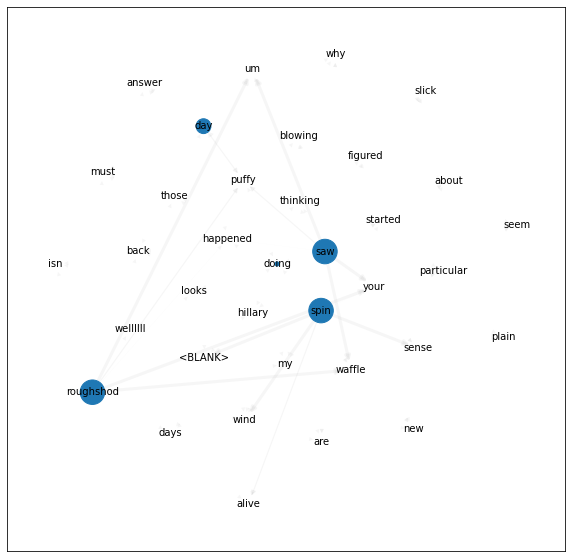

In [33]:
fig = plt.figure(figsize=(10,10))
#pos=nx.spring_layout(G)
#pos=nx.spiral_layout(G)

doc_weigs = np.array(weigths[i,:n,0].tolist())
doc_weigs /= doc_weigs.mean(axis=0)
doc_weigs = (doc_weigs - doc_weigs.min(axis=0)) / (doc_weigs.max(axis=0) - doc_weigs.min(axis=0))

node_sizes  = [ doc_weigs[nid]*600 for nid in G.nodes ]
node_labels = { nid: inv_dict[nid] for nid in G.nodes }
#edge_alphas = { nid: 1.-doc_weigs[nid] for nid in G.nodes }
edge_widths = { nid: doc_weigs[nid]*3. for nid in G.nodes }

ax = nx.draw_networkx_nodes(G, pos=pos, node_size=node_sizes)
ax = nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=10)
ax = nx.draw_networkx_edges(G, pos=pos, edge_color='darkgray', width=edge_widths, alpha=0.1)
#for nid, alpha in tqdm(edge_alphas.items(), total=len(edge_alphas)):
#    ax = nx.draw_networkx_edges(G, pos=pos, nodelist=[nid], edge_color='darkgray', width=edge_widths, alpha=alpha)

In [34]:
doc_weigs

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.36731016, 0.        , 0.        , 0.        , 0.        ,
       1.        , 0.        , 0.        , 0.        , 0.        ,
       0.99984272, 0.        , 0.        , 0.0291739 , 0.        ,
       1.        ])

In [35]:
doc_weigs, doc_weigs2

NameError: name 'doc_weigs2' is not defined

In [ ]:
G = nx.DiGraph()

In [ ]:
len(sp_matrix.nonzero()[0])

In [ ]:
"""
acm ####################################################################################
Train loss: 1.6009/1.6089 ACC: 0.94886                                                                                                    
Val loss: 1.7718 ACC: 0.77475                                                                                                    
New Best Val loss: 1.7718                                                                                                    
Test loss: 1.7678 ACC: 0.78557  79.92

Train loss: 1.7209/1.6095 ACC: 0.82338                                                                                                    
Val loss: 1.7595 ACC: 0.78236                                                                                                    
New Best Val loss: 1.7595                                                                                             
Test loss: 1.7585 ACC: 0.78557                                                                                                    

20ng ####################################################################################
Train loss: 2.0907/2.0787 ACC: 0.98845                                                                                                    
Val loss: 2.1869 ACC: 0.90803                                                                                                    
New Best Val loss: 2.1869                                                                                                    
Test loss: 2.178 ACC: 0.91068   92.65

Train loss: 2.1603/2.1249 ACC: 0.92511                                                                                                    
Val loss: 2.1842 ACC: 0.90645                                                                                                    
drop: 0.8436
New Best Val loss: 2.1842                                                                                                   
Test loss: 2.1705 ACC: 0.91226                                                                                                    

reut ####################################################################################
Train loss: 3.7735/3.5191 ACC: 0.74734            acm                                                                                        
Val loss: 3.8554 ACC: 0.6763                                                                                                    
New Best Val loss: 3.8554                                                                                                    
Test loss: 3.8493 ACC: 0.6837  72.67

Train loss: 3.7443/3.8521 ACC: 0.77727                                                                                                    
Val loss: 3.808 ACC: 0.71037                                                                                                     
New Best Val loss: 3.808
Test loss: 3.8461 ACC: 0.70444                                                                                                    

webkb ####################################################################################
Train loss: 1.2228/1.2037 ACC: 0.9504                                                                                                     
Val loss: 1.3787 ACC: 0.80316                                                                                                    
New Best Val loss: 1.3787                                                                                                    
Test loss: 1.3857 ACC: 0.78858   81.53

Epoch: 45
Train loss: 1.2392/1.2909 ACC: 0.9295                                                                                                     
Val loss: 1.3838 ACC: 0.78736                                                                                                    
New Best Val loss: 1.3838
Test loss: 1.3814 ACC: 0.78372                                                                                                    

"""

In [ ]:
dt_h = ab.dt_emb( x_packed )
dt_h.shape

In [ ]:
bx_packed = x_packed == 0
doc_sizes = bx_packed.logical_not().sum(dim=1).view(batch_size, 1)
pad_mask  = bx_packed.logical_not()
pad_mask  = pad_mask.view(*bx_packed.shape, 1)
pad_mask  = pad_mask.logical_and(pad_mask.transpose(1, 2))
pad_mask.shape, doc_sizes.shape, bx_packed.shape 

In [ ]:
doc_means = (bx_packed.logical_not().view(*bx_packed.shape, 1) * dt_h).sum(axis=1) / doc_sizes
doc_means = doc_means.view(*doc_means.shape, 1).transpose(1,2)
doc_means.shape

In [ ]:
n_dt_h = dt_h/doc_sizes.view(*doc_sizes.shape, 1)
n_dt_h = (doc_means - n_dt_h)
n_dt_h.shape

In [ ]:
y_pred_t      = pred_docs_t.argmax(axis=1)
correct_t     = (y_pred_t == y_t).sum().item()
total_t       = len(y_t)
correct_t/total_t

In [ ]:
docs_offsets_t

In [ ]:
terms_idx_t[:docs_offsets_t[batch_size]]

In [ ]:
batch_off_test  = docs_offsets_t[batch_size]
batch_tidx_test = terms_idx_t[:batch_off_test]
h_terms_test    = sc.tt_emb( batch_tidx_test )
dirh_terms_test = sc.tt_dir_map( h_terms_test )

W = torch.matmul( h_terms_test, dirh_terms_test.T )
W = F.leaky_relu( W, negative_slope=sc.mask.negative_slope)
W = F.sigmoid(W)
W

In [ ]:
k = [ batch_tidx_test[ docs_offsets_t[i-1]:docs_offsets_t[i] ] for i in range(1, batch_size) ]
k.append( batch_tidx_test[ docs_offsets_t[batch_size-1]:docs_offsets_t[batch_size] ] )
x_packed = pad_sequence(k, batch_first=True, padding_value=0)
tt_emb = sc.tt_emb( x_packed )
len(k)

In [ ]:
x_packed = pad_sequence(k, batch_first=True, padding_value=0)
tt_emb = sc.tt_emb( x_packed )

In [ ]:
tt_emb.transpose(0,1)

In [ ]:
a = [terms_idx, terms_idx]
torch.stack(a)

In [ ]:
F.softmax(pred_docs_t).argmax(axis=1)

In [ ]:
y_val

In [ ]:
(y_t == F.softmax(pred_docs_t).argmax(axis=1)).sum().item()/y_t.shape[0]

In [ ]:
terms_idx_t, docs_offsets_t

In [ ]:
shifts = sc._get_shift_(docs_offsets_t, terms_idx_t.shape[0])

In [ ]:
zipado = zip(docs_offsets_t, shifts)
#next(zipado)
start,size = next(zipado)

In [ ]:
w = sc.tt_emb( terms_idx_t[start:start+size] )
w1 = sc.tt_dir_map( w )
w = torch.matmul( w, w1.T )
w = F.leaky_relu( w, negative_slope=sc.negative_slope)
w = F.sigmoid(w)
#w = F.tanh(w)
#w = F.relu(w)
#w = w.mean(axis=1)
#w = F.softmax(w)
w,w1

In [ ]:
w.round().sum() / (w.shape[0]*w.shape[1])

In [ ]:
inv_mapper = { v:k for (k,v) in tokenizer.node_mapper.items() }

In [ ]:
terms_idx[start:start+size]

In [ ]:
fold.X_val[0]

In [ ]:
bla = w.mean(axis=1)
bla = F.softmax(bla)
#bla = bla/torch.clamp(bla.sum(), 0.0001)
bla

In [ ]:
[ (i, tid.item(),inv_mapper[tid.item()], wei.item()) for i, (tid, wei) in enumerate(zip(terms_idx[start:start+size], bla)) ]

In [ ]:
w

In [ ]:
w.mean(axis=1)

In [ ]:
w.shape

In [ ]:
norm = nn.BatchNorm1d(num_features=1).to(device)

bla2 = norm(bla.view(-1, 1)).squeeze()
bla2 = F.sigmoid(bla2)
bla2

In [ ]:
1

In [ ]:
ma = nn.MultiheadAttention(300, 300).to(device)
ma

In [ ]:
torch.__version__

In [ ]:
a,b = w.shape
w_ = w.view(a,1,b)
w1_ = w1.view(a,1,b)

attn_output = ma(w_, w1_, w_, need_weights=False)

attn_output.view(a,b)
attn_output_weights.view(a,a)

In [ ]:
attn_output.view(a,b).shape

In [ ]:
attn_output_weights.view(a,a)

In [ ]:
F.softmax(torch.Tensor([[0.0718, 0.0716, 0.0712, 0.0714, 0.0721, 0.0710, 0.0712, 0.0714, 0.0710,
         0.0719, 0.0711, 0.0712, 0.0718, 0.0714],
        [0.0722, 0.0709, 0.0710, 0.0709, 0.0728, 0.0723, 0.0709, 0.0709, 0.0719,
         0.0712, 0.0709, 0.0707, 0.0725, 0.0707],
        [0.0711, 0.0715, 0.0710, 0.0713, 0.0710, 0.0712, 0.0718, 0.0713, 0.0709,
         0.0725, 0.0716, 0.0719, 0.0710, 0.0719],
        [0.0721, 0.0717, 0.0714, 0.0713, 0.0717, 0.0714, 0.0711, 0.0710, 0.0713,
         0.0717, 0.0710, 0.0712, 0.0720, 0.0711],
        [0.0722, 0.0711, 0.0710, 0.0710, 0.0737, 0.0716, 0.0709, 0.0705, 0.0714,
         0.0719, 0.0707, 0.0707, 0.0731, 0.0702],
        [0.0714, 0.0716, 0.0708, 0.0711, 0.0718, 0.0713, 0.0712, 0.0717, 0.0712,
         0.0724, 0.0713, 0.0712, 0.0716, 0.0714],
        [0.0712, 0.0714, 0.0713, 0.0713, 0.0722, 0.0716, 0.0709, 0.0714, 0.0714,
         0.0717, 0.0713, 0.0713, 0.0716, 0.0713],
        [0.0716, 0.0707, 0.0712, 0.0714, 0.0717, 0.0715, 0.0714, 0.0715, 0.0712,
         0.0721, 0.0711, 0.0714, 0.0717, 0.0715],
        [0.0717, 0.0713, 0.0708, 0.0710, 0.0725, 0.0717, 0.0714, 0.0709, 0.0712,
         0.0712, 0.0712, 0.0717, 0.0720, 0.0714],
        [0.0709, 0.0712, 0.0713, 0.0712, 0.0713, 0.0713, 0.0714, 0.0719, 0.0712,
         0.0724, 0.0715, 0.0715, 0.0717, 0.0713],
        [0.0715, 0.0716, 0.0712, 0.0708, 0.0725, 0.0717, 0.0712, 0.0714, 0.0714,
         0.0717, 0.0713, 0.0706, 0.0718, 0.0712],
        [0.0726, 0.0711, 0.0713, 0.0706, 0.0737, 0.0721, 0.0709, 0.0707, 0.0714,
         0.0708, 0.0706, 0.0705, 0.0730, 0.0707],
        [0.0718, 0.0711, 0.0714, 0.0715, 0.0725, 0.0707, 0.0707, 0.0711, 0.0712,
         0.0728, 0.0711, 0.0713, 0.0719, 0.0709],
        [0.0712, 0.0716, 0.0713, 0.0712, 0.0717, 0.0707, 0.0708, 0.0721, 0.0709,
         0.0728, 0.0713, 0.0716, 0.0711, 0.0715]]).sum(axis=0))

In [ ]:
class NotTooSimpleClassifier(nn.Module):
    def __init__(self, vocab_size, hidden_l, nclass, dropout1=0.1, dropout2=0.1, negative_slope=99,
                 initrange = 0.5, scale_grad_by_freq=False, device='cuda:0'):
        super(NotTooSimpleClassifier, self).__init__()
        
        self.dt_emb = nn.Embedding(vocab_size, hidden_l, scale_grad_by_freq=scale_grad_by_freq)
        self.tt_emb = nn.Embedding(vocab_size, hidden_l, scale_grad_by_freq=scale_grad_by_freq)
        
        self.undirected_map = nn.Linear(hidden_l, hidden_l)
        
        self.fc = nn.Linear(hidden_l, nclass)
        self.drop1 = nn.Dropout(dropout1)
        self.drop2 = nn.Dropout(dropout2)
        
        self.norm = nn.BatchNorm1d(1)
        
        self.initrange = initrange
        self.nclass = nclass
        self.negative_slope = negative_slope
        
        self.init_weights()
        
        #self.labls_emb = nn.Embedding(graph_builder.n_class, 300)
    
    def forward(self, terms_idxs, docs_offsets):
        n = terms_idxs.shape[0]
        weights = []
        shifts = self._get_shift_(docs_offsets, n)
        
        terms_h1 = self.tt_emb(terms_idxs)
        terms_h1 = self.drop1(terms_h1)
        
        terms_h2 = self.undirected_map( terms_h1 )
        #terms_h2 = self.drop1( terms_h2 )
        for start,size in zip(docs_offsets, shifts):
            w  = terms_h1[start:start+size]
            w1 = terms_h2[start:start+size]
            w = torch.matmul( w, w1.T )
            w = F.leaky_relu( w, negative_slope=self.negative_slope)
            w = F.sigmoid(w-5.5)
            w = w.mean(axis=1)
            w = F.softmax(w)
            #w = w / torch.clamp(w.sum(), 0.0001)
            weights.append( w )
        
        weights = torch.cat(weights)
        #weights = self.norm(weights.view(-1, 1)).squeeze()
        #weights = F.sigmoid(weights)
        
        h_docs  = F.embedding_bag(self.dt_emb.weight, terms_idxs, docs_offsets, per_sample_weights=weights, mode='sum')
        h_docs = self.drop2( h_docs )
        pred_docs = self.fc( h_docs )
        return pred_docs

    def init_weights(self):
        self.dt_emb.weight.data.uniform_(-self.initrange, self.initrange)
        self.tt_emb.weight.data.uniform_(-self.initrange, self.initrange)
        
    def _get_shift_(self, offsets, lenght):
        shifts = offsets[1:] - offsets[:-1]
        last = torch.LongTensor([lenght - offsets[-1]]).to( offsets.device )
        return torch.cat([shifts, last])